# Part 1

> Calculate the homography 

The image orientation remained unchanged or changed in a different manner.


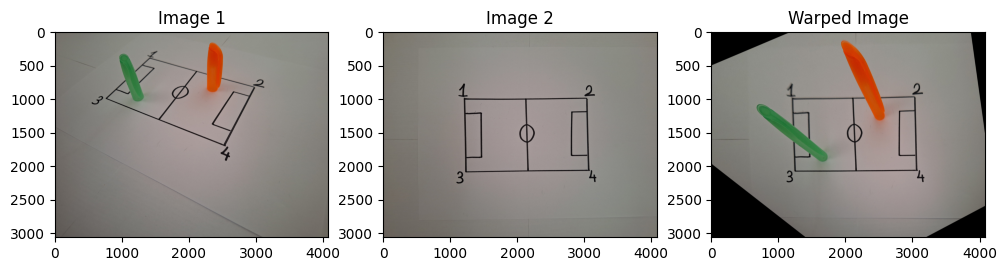

In [1]:
# https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

import numpy as np
import cv2
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10

image_path = 'player_field_2.jpg'

# Load images
img1 = cv2.imread(image_path)
img2 = cv2.imread('reference_image.jpg')

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test to find good matches
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    # Extract matched keypoints
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    
    # Compute homography using RANSAC
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Transform the corners of img1 to see if they flipped
    img1_corners = np.float32([[0, 0], [img1.shape[1], 0], [img1.shape[1], img1.shape[0]], [0, img1.shape[0]]]).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(img1_corners, M)

    # Check if the top left corner is now below the bottom right corner
    is_flipped = transformed_corners[0, 0, 1] > transformed_corners[2, 0, 1]

    # Print result
    if is_flipped:
        print("The image might have become upside down.")
    else:
        print("The image orientation remained unchanged or changed in a different manner.")


    # Warp img1 onto img2 using the computed homography
    warped_img1 = cv2.warpPerspective(img1, M, (img2.shape[1], img2.shape[0]))
    
    # Visualize the result
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)), plt.title('Image 1')
    plt.subplot(1, 3, 2), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)), plt.title('Image 2')
    plt.subplot(1, 3, 3), plt.imshow(cv2.cvtColor(warped_img1, cv2.COLOR_BGR2RGB)), plt.title('Warped Image')
    plt.show()

    # Save the result of homography
    cv2.imwrite("warped_image.jpg", warped_img1)
else:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))


# Part 2

> Extract the players

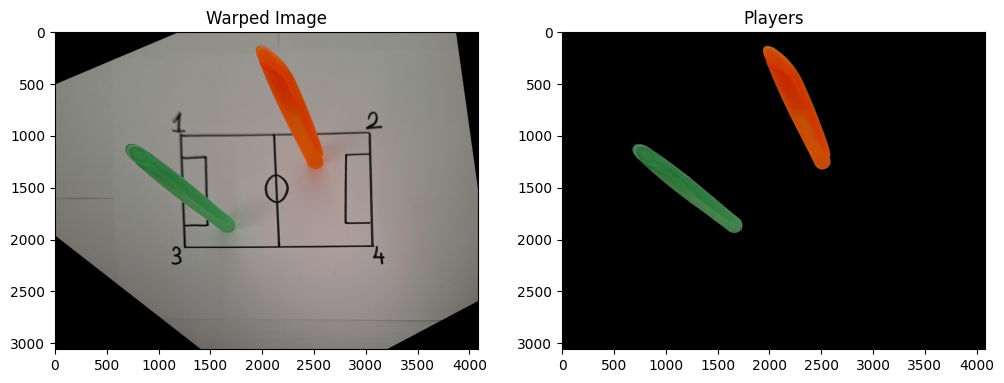

True

In [2]:
# Load image
image = cv2.imread('warped_image.jpg')

# Convert to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define color thresholds (orange and green)
lower_orange = np.array([5, 150, 100], dtype="uint8")  
upper_orange = np.array([25, 255, 255], dtype="uint8")

lower_green = np.array([40, 50, 50], dtype="uint8")  
upper_green = np.array([80, 255, 255], dtype="uint8")

# Create masks for orange and green using color thresholds
mask_orange = cv2.inRange(hsv_image, lower_orange, upper_orange)
mask_green = cv2.inRange(hsv_image, lower_green, upper_green)

# Combine masks using bitwise OR (players can have orange or green)
combined_mask = cv2.bitwise_or(mask_orange, mask_green)

# Apply mask to original image
filtered_image = cv2.bitwise_and(image, image, mask=combined_mask)

# Morphological operations for noise reduction
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
opening = cv2.morphologyEx(filtered_image, cv2.MORPH_OPEN, kernel)

# Visualize the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Warped Image')
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB)), plt.title('Players')
plt.show()


# Save the result
cv2.imwrite('players.jpg', filtered_image)


> Put the circles under the players

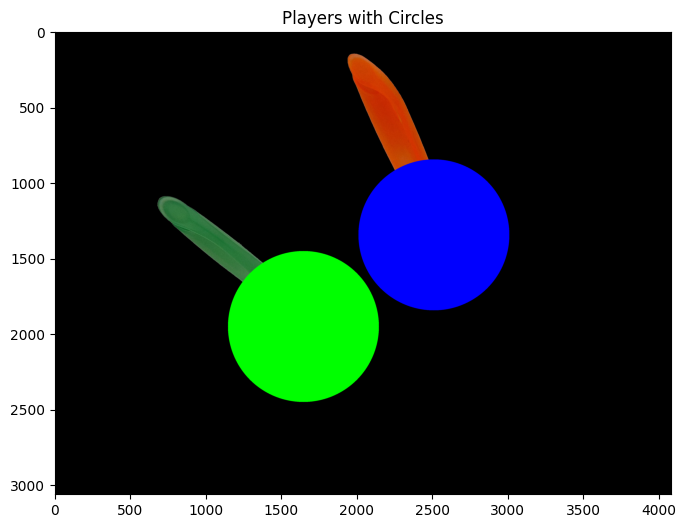

True

In [3]:
import random
# Load image 
image = cv2.imread('players.jpg')

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to create binary image
_, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Check if any contours were found
if len(contours) > 0:
  
  # Set a threshold for minimum contour area 
    min_contour_area = 100
 
    if is_flipped == False:
        # Initialize list to store bottommost points
        bottommost_points = []

        # Iterate through contours to find the bottommost point for each contour
        for contour in contours:
            # Calculate the area of the contour
            area = cv2.contourArea(contour)

            # Exclude contours with small areas (likely noise)
            if area < min_contour_area:
                continue

            # Initialize variables to keep track of the bottommost point for the current contour
            bottommost_point = None
            max_y = float('-inf')  # Set to negative infinity

            # Iterate through the contour points
            for point in contour:
                x, y = point[0]  # Extract x and y coordinates

                # Check if the current point's y-coordinate is greater than the maximum recorded
                if y > max_y:
                    bottommost_point = (x, y)
                    max_y = y

            # Add the bottommost point for the current contour to the list
            bottommost_points.append(bottommost_point)

        # Draw a circle at each topmost point 
        for point in bottommost_points:
            if point is not None:
                cv2.circle(image, point, radius=500, color=colors[random.randint(0,5)], thickness=-1)
 
    else:
        # Initialize list to store topmost points
        topmost_points = []

        # Iterate through contours to find the topmost point for each contour
        for contour in contours:
            # Calculate the area of the contour
            area = cv2.contourArea(contour)
          
            # Exclude contours with small areas (likely noise)
            if area < min_contour_area:
                continue
          
            # Initialize variables to keep track of the topmost point for the current contour
            topmost_point = None
            min_y = float('inf')  # Set to positive infinity
          
            # Iterate through the contour points
            for point in contour:
                x, y = point[0]  # Extract x and y coordinates
              
                # Check if the current point's y-coordinate is less than the minimum recorded
                if y < min_y:
                    topmost_point = (x, y)
                    min_y = y
          
            # Add the topmost point for the current contour to the list
            topmost_points.append(topmost_point)

        # Draw a circle at each topmost point on the mask
        for point in topmost_points:
            if point is not None:
                cv2.circle(image, point, radius=500, color=colors[random.randint(0,5)], thickness=-1)
              
            
else:
    print("No contours found in the image!")


# Visualize the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Players with Circles')
plt.show()

# Display the image with circles
cv2.imwrite('players_with_circles.jpg', image)



> Remove the parts of circles which should be behind the players

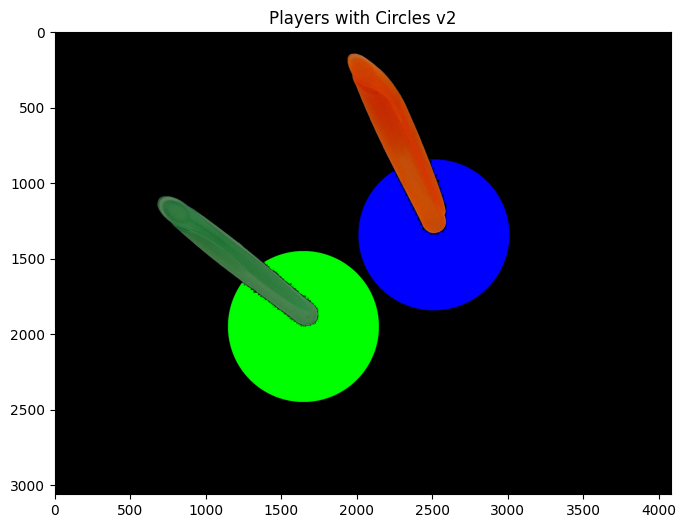

True

In [4]:
import cv2
import numpy as np

# Load the original image of players and the image with circles
original_image = cv2.imread('players.jpg')
circle_image = cv2.imread('players_with_circles.jpg')

# Convert the original image to grayscale
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Find contours in the original image
contours, _ = cv2.findContours(gray_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert the circle image to grayscale
circle_gray = cv2.cvtColor(circle_image, cv2.COLOR_BGR2GRAY)

# Threshold the circle image to obtain a binary mask
_, circle_mask = cv2.threshold(circle_gray, 0, 255, cv2.THRESH_BINARY)

# Create a blank mask for the contours
mask = np.zeros_like(gray_image)

# Draw contours on the mask
cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

# Invert the mask to keep the background behind the players
mask = cv2.bitwise_not(mask)

# Apply the inverted mask to the circle mask to keep only the parts behind the objects
result = cv2.bitwise_and(circle_mask, mask)

# Apply the result to the circle image
circle_image = cv2.bitwise_and(circle_image, circle_image, mask=result)

# Combine the circle image with the original image
result_image = cv2.add(original_image, circle_image)

# Visualize the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1), plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)), plt.title('Players with Circles v2')
plt.show()

# Display the image with circles
cv2.imwrite('players_with_circles.jpg', result_image)



> Apply inverse homography to get the original perspective

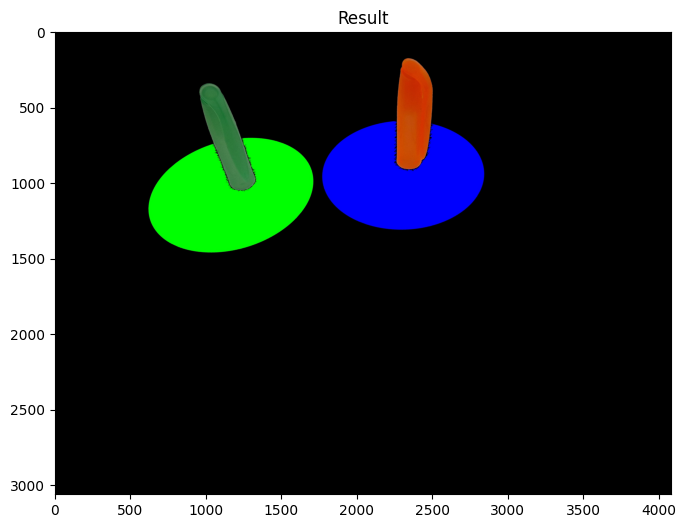

True

In [5]:
# Load the transformed image
transformed_image = cv2.imread('players_with_circles.jpg')


# Compute the inverse homography matrix
M_inv = np.linalg.inv(M)

# Warp the transformed image back to its original coordinates
inverse_transformed_image = cv2.warpPerspective(transformed_image, M_inv, (transformed_image.shape[1], transformed_image.shape[0]))

# Visualize the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1), plt.imshow(cv2.cvtColor(inverse_transformed_image, cv2.COLOR_BGR2RGB)), plt.title('Result')
plt.show()

# Display the image with circles
cv2.imwrite('result.jpg', inverse_transformed_image)


> Add the soccer field to the background

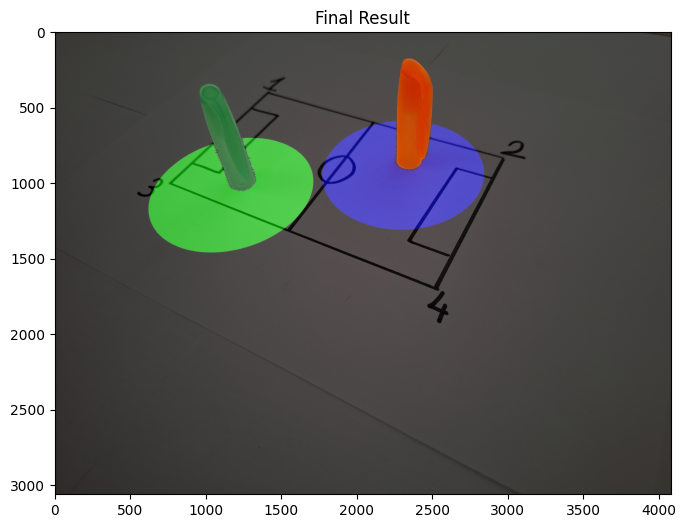

True

In [6]:

# Load the inverse transformed image
inverse_transformed_image = cv2.imread('result.jpg')

# Load the background image
background_image = cv2.imread(image_path)


# Alpha blending
alpha = 0.5
result = cv2.addWeighted(inverse_transformed_image, alpha, background_image, 1 - alpha, 0)

# Visualize the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1), plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB)), plt.title('Final Result')
plt.show()

# Display the image with circles
cv2.imwrite('final_result.jpg', result)
